## Optimization Attempt 4
In this optimization attempt, we use Mean Aerterial Pressure (MAP) in place of systolic and diasystolic pressure (as calculated in our data cleaning)

In [3]:
# Importing dependencies
import pandas as pd
from pathlib import Path
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline


In [4]:
# Reading in the data
file_path = Path('../Resources/cleaned_data_map.csv')
df = pd.read_csv(file_path)
df.head()

,sex,age,education,smokingStatus,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,BMI,heartRate,glucose,CHDRisk,MAP
0,1.0,39,4,0.0,0,0,0,0,0,195,26.97,80,77,0,82.000000
1,0.0,46,2,0.0,0,0,0,0,0,250,28.73,95,76,0,94.333333
2,1.0,48,1,1.0,20,0,0,0,0,245,25.34,75,70,0,95.833333
3,0.0,61,3,1.0,30,0,0,1,0,225,28.58,65,103,1,113.333333
4,0.0,46,3,1.0,23,0,0,0,0,285,23.10,85,85,0,99.333333


In [5]:
# Separating target variables and features
y = df['CHDRisk']
X = df.drop(columns='CHDRisk')

In [6]:
# Count Values
y.value_counts()

CHDRisk
0    3084
1     553
Name: count, dtype: int64

In [7]:
# Splitting the data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [8]:
# Count Values
y_train.value_counts()

CHDRisk
0    2312
1     415
Name: count, dtype: int64

In [9]:
# Using synthetic minority over-sampling technique to balance the target variable conditions in the training data
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [10]:
y_train_resampled.value_counts()

CHDRisk
0    2312
1    2312
Name: count, dtype: int64

In [11]:
X_train_resampled.shape

(4624, 14)

In [12]:
y_train_resampled.shape

(4624,)

In [13]:
# Scaling the feature variables
scaler = StandardScaler()
X_scaler = scaler.fit(X_train_resampled)

X_train_scaled = X_scaler.transform(X_train_resampled)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
# Instantiating the model
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [15]:
# Training the model
rf_model = rf_model.fit(X_train_scaled, y_train_resampled)

In [16]:
# Making predictions with the testing data
test_predictions = rf_model.predict(X_test_scaled)

## Testing Data Results

In [18]:
# Creating the confusion matrix
cm = confusion_matrix(y_test, test_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy and recall scores
acc_score = accuracy_score(y_test, test_predictions)

In [19]:
# Printing the results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, test_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,704,68
Actual 1,105,33


Accuracy Score : 0.8098901098901099
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       772
           1       0.33      0.24      0.28       138

    accuracy                           0.81       910
   macro avg       0.60      0.58      0.58       910
weighted avg       0.79      0.81      0.80       910



## Feature Importances

In [20]:
# Calculating feature importances and listing by importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.15405540904446013, 'sex'),
 (0.15107800685571443, 'age'),
 (0.12704032821102737, 'MAP'),
 (0.10886756545465835, 'totChol'),
 (0.09977237455706477, 'BMI'),
 (0.09777906134229467, 'glucose'),
 (0.0878414262210252, 'heartRate'),
 (0.05541298638282085, 'cigsPerDay'),
 (0.050474225889867434, 'education'),
 (0.044482585590324135, 'smokingStatus'),
 (0.015124676201683365, 'prevalentHyp'),
 (0.004293085491826232, 'diabetes'),
 (0.002871266088725828, 'BPMeds'),
 (0.0009070026685072387, 'prevalentStroke')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

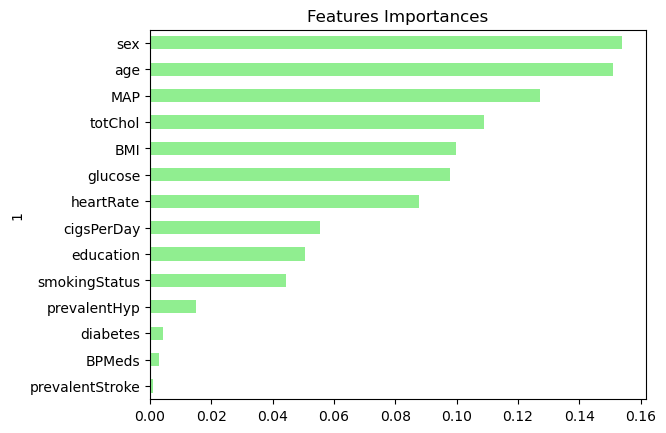

In [21]:
# Visualizing the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

## Using k-fold cross-validation to ensure model is not overfitting

In [22]:
# Setting up k-fold cross-validation
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)

In [23]:
X_scaled = scaler.fit_transform(X)
#Perform cross-validation
cv_results = cross_val_score(rf_model, X_scaled, y, cv=kf, scoring='accuracy')

# Print cross-validation results
print(f'Cross-validation results (accuracy): {cv_results}')
print(f'Mean cross-validation accuracy: {cv_results.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_results.std()}')

Cross-validation results (accuracy): [0.84478022 0.8489011  0.85006878 0.84731774 0.85419532]
Mean cross-validation accuracy: 0.849052632374503
Standard deviation of cross-validation accuracy: 0.0031230153938633268


In [24]:
# Saving the model
# import joblib
# joblib_file = "rf_model.joblib"
# joblib.dump(rf_model, joblib_file)

In [25]:
# import pickle
# with open("rf_model.pkl", "wb") as file:
#     pickle.dump(rf_model, file)